# CUSTOMHyS for Designing Microchannel Heat Sinks

## 0. Packages' installation and loading

In [1]:
%pwd

'C:\\Users\\memo_\\PycharmProjects\\Microchannels'

Instalamos el paquete de Customhys directo del repositorio

In [2]:
!pip3 install install customhys==1.0.1.dev1

You should consider upgrading via the 'C:\Users\memo_\PycharmProjects\Microchannels\venv\Scripts\python.exe -m pip install --upgrade pip' command.


Cargamos los paquetes que vamos a utilizar

In [3]:
import numpy as np
from microchannels import Microchannel
from materials import Copper, Air, Titanium, Aluminium, Graphite, Silicon, AlNF, TiONF
from customhys import metaheuristic as mh

## 1. Microchannel Heat Sink model preparation
En esta parte, preparamos el modelo para utilizarlo y evaluar una configuración de parámetros de diseño en la función objetivo, que en este caso será al generación de entropía.

In [4]:
class MicrochannelDesign():
    def __init__(self):
        self.model = Microchannel(base=Copper(), coolant=Air())
        #self.max_search_range = np.array([self.model.W_d/10, self.model.W_d/10, 0.005])
        #self.min_search_range = np.array([1e-24, 1e-12, 1e-8])
        self.max_search_range = np.array([2.65e-5, 20.4e-5, 0.009])
        self.min_search_range = np.array([4.53e-5, 13.6e-5, 0.005])
        self.func_name = 'Microchannel entropy generation model'

    def get_func_val(self, variables):
        self.model.w_w = variables[0]
        self.model.w_c = variables[1]
        self.model.G_d = variables[2]
        #print(self.model.G_d)
        #print(self.model.alpha)
        #print(self.model.beta)
        return self.model.sgen

    def get_formatted_problem(self, is_constrained=True):
        return dict(function=self.get_func_val,
                    boundaries=(self.min_search_range, self.max_search_range),
                    is_constrained=is_constrained)

fun = MicrochannelDesign()

## 2. Metaheuristic preparation

In [6]:
# Primero cargamos la colección de operadores
with open('./source/collections/' + 'default.txt', 'r') as operators_file:
    heuristic_space = [eval(line.rstrip('\n')) for line in operators_file]

Esta es la parte en donde, utilizando los operadores, ensamblamos la metaheurística a usar:

In [15]:
# Metaheuristic 1: Random Search
# heur = [('random_search', {'scale': 0.01, 'distribution': 'uniform'}, 'greedy')]

# Metaheuristic 2: Particle Swarm & Genetic Linear Crossover with Random Pairing and Metropolis Selection
#heur = [('swarm_dynamic', {'factor': 0.7, 'self_conf': 2.54, 'swarm_conf': 2.56, 'version': 'inertial', 'distribution': 'uniform'}, 'all'),
#        ('genetic_crossover', {'pairing': 'random', 'crossover': 'linear_0.5_0.5', 'mating_pool_factor': 0.4}, 'metropolis')]

heur = [('genetic_crossover',
  {'pairing': 'rank', 'crossover': 'linear_0.5_0.5', 'mating_pool_factor': 0.4},
  'all'),
        ('swarm_dynamic',
  {'factor': 0.7, 'self_conf': 2.54, 'swarm_conf': 2.56, 'version': 'inertial', 'distribution': 'gaussian'},
  'probabilistic'),
        ('genetic_crossover',
  {'pairing': 'random', 'crossover': 'blend', 'mating_pool_factor': 0.4},
  'probabilistic')]


#Metaheuristic 3: Genetic Algorithm
#heur = [('genetic_crossover', {'pairing': 'tournament_2_100', 'crossover': 'single', 'mating_pool_factor': 0.4}, 'all'), ('genetic_mutation', {'scale': 1.0, 'elite_rate': 0.1, 'mutation_rate': 0.25, 'distribution': 'uniform'}, 'all')]

Aquí terminamos de definirla empleando CUSTOMHyS


In [16]:
met = mh.Metaheuristic(fun.get_formatted_problem(is_constrained=True), heur , num_iterations=100)

## 3. Run designing process

In [17]:
# Aquí corremos la metaheurística seleccionada
met.verbose = True  # Se puede comentar para que no muestre todo el log
met.run()


Search operators to employ:
genetic_crossover(pairing='rank',crossover='linear_0.5_0.5',mating_pool_factor=0.4) with all
swarm_dynamic(factor=0.7,self_conf=2.54,swarm_conf=2.56,version='inertial',distribution='gaussian') with probabilistic
genetic_crossover(pairing='random',crossover='blend',mating_pool_factor=0.4) with probabilistic
--------------------------------------------------
1
pop. radius: 1.419155017643375
x_best = [2.65e-05 2.04e-04 5.00e-03], f_best = 0.17220074473297137
2
pop. radius: 0.7295353160932749
x_best = [2.65e-05 2.04e-04 5.00e-03], f_best = 0.17220074473297137
3
pop. radius: 0.03903480018038563
x_best = [2.65000000e-05 2.02627052e-04 5.00000000e-03], f_best = 0.172191663432088
4
pop. radius: 0.035610319131157864
x_best = [2.65000000e-05 2.02864512e-04 5.00000000e-03], f_best = 0.17214477968532144
5
pop. radius: 0.03308539537106214
x_best = [2.65000000e-05 2.02864512e-04 5.00000000e-03], f_best = 0.17214477968532144
6
pop. radius: 0.0368014437687344
x_best = [2.6

## 4. Results' visualization

En esta primera gráfica, solo veremos la evolución de la función objetivo (generación de entropía)

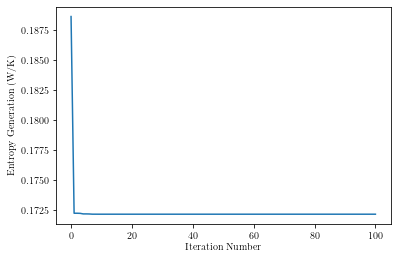

In [18]:
import matplotlib.pyplot as plt

plt.plot(met.historical["fitness"])
plt.ylabel(r'Entropy Generation (W/K)')
plt.xlabel(r'Iteration Number')
plt.show()

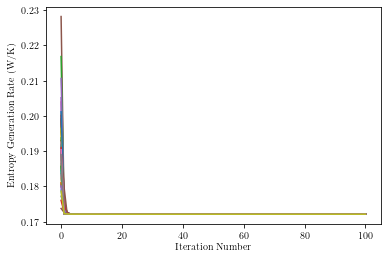

In [19]:
for i in range(1,50):
    met = mh.Metaheuristic(fun.get_formatted_problem(is_constrained=True), heur , num_iterations=100)
    met.run()
    plt.plot(met.historical["fitness"])
plt.ylabel(r'Entropy Generation Rate (W/K)')
plt.xlabel(r'Iteration Number')
plt.gcf()
plt.savefig('resultsMH.jpg')
plt.show()



In [15]:
# from source import experiment as ex
# expe = ex.Experiment()
# expe.hh_configr
# expe.exp_config
# expe.prob_config
# expe.run()
from customhys import hyperheuristic as hh
prob = fun.get_formatted_problem(is_constrained=True)
hyp = None
for i in range(1,30):
    del hyp
    hyp = hh.Hyperheuristic(heuristic_space=heuristic_space, problem=prob, file_label="MC_results_Copper_Air_%d"%i
    )
    sol, perf, e_sol = hyp.run()
    print( sol, perf, e_sol, "\n\n")

KeyboardInterrupt: 

In [21]:
met.historical

{'fitness': [array(0.17864928),
  array(0.17227999),
  array(0.17220074),
  array(0.17214032),
  array(0.17214032),
  array(0.17214032),
  array(0.17214032),
  array(0.17214032),
  array(0.17214032),
  array(0.17214032),
  array(0.17214032),
  array(0.17214032),
  array(0.17214032),
  array(0.17214032),
  array(0.17214032),
  array(0.17213927),
  array(0.17212368),
  array(0.17212368),
  array(0.17212368),
  array(0.17212368),
  array(0.17212368),
  array(0.17212368),
  array(0.17212269),
  array(0.17212204),
  array(0.17212204),
  array(0.172121),
  array(0.172121),
  array(0.17212095),
  array(0.17212095),
  array(0.17212095),
  array(0.17212054),
  array(0.17212054),
  array(0.17212054),
  array(0.17212054),
  array(0.17212039),
  array(0.17212027),
  array(0.17212021),
  array(0.17212017),
  array(0.17212014),
  array(0.17212012),
  array(0.17212003),
  array(0.17211998),
  array(0.17211998),
  array(0.17211998),
  array(0.17211997),
  array(0.17211996),
  array(0.1721199),
  array

In [ ]:
parameters=dict(
        cardinality=3,  # Max. numb. of SOs in MHs, lvl:1
        num_iterations=500,  # Iterations a MH performs, lvl:1
        num_agents=300,  # Agents in population,     lvl:1
        num_replicas=30,  # Replicas per each MH,     lvl:2
        num_steps=100,  # Trials per HH step,       lvl:2
        stagnation_percentage=0.5,  # Stagnation percentage,    lvl:2
        max_temperature=200,  # Initial temperature (SA), lvl:2
        cooling_rate=0.05,  # Cooling rate (SA),        lvl:2)
        compute_replicas_in_parallel=False,
        compute_agents_in_parallel=True)